# Import Libraries

In [ ]:
!pip install --upgrade tensorflow-gpu
!pip install nltk
!pip install gensim 
!pip install plotly

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
nltk.download('punkt')
import re
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Dataset

In [ ]:
# loading the data
real = pd.read_csv('/content/drive/MyDrive/Dataset/True.csv')
fake =pd.read_csv('/content/drive/MyDrive/Dataset/Fake.csv')

In [ ]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Checking Null Values

In [ ]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Preprocessing

Adding Ground Truth Value isfake

In [ ]:
real['isfake'] = 1
fake['isfake'] = 0

Merging real and fake dataset

In [ ]:
data = pd.concat([real, fake]).reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   isfake   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
#Dropping column date as it is irrelevant 
data.drop(columns = ['date'], inplace = True)

#Concatenation of both title and text of news
data['title_text_merged'] = data['title'] + ' ' + data['text']
data.head()

,title,text,subject,isfake,title_text_merged
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [ ]:
stopWords = stopwords.words('english')
stopWords.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
def preProcess(text):
  final = []
  for token in text:
    if(2<3):
      print(unique_list)
      final.append(token)
  return final

In [ ]:
# Remove stopwords and remove words with 2 or less characters
def preprocessing(text):
    processed = []
    file_1 = gensim.utils.simple_preprocess(text)
    for i in file_1:
        st = gensim.parsing.preprocessing.STOPWORDS
        length = len(i)
        if i not in st:
          if length > 3:
            if i not in stopWords:
              processed.append(i)
    return processed

In [ ]:
data['tokenization'] = data['title_text_merged'].apply(preprocessing)

In [ ]:
data.head()

,title,text,subject,isfake,title_text_merged,tokenization
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


In [ ]:
# join the tokens into a single string
data['tokenization_merged'] = data['tokenization'].apply(lambda x: " ".join(x))
data.head()

,title,text,subject,isfake,title_text_merged,tokenization,tokenization_merged
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


Splitting data into train and test set

In [ ]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.tokenization_merged, data.isfake, test_size = 0.25)

In [ ]:
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
                     annot=True, 
                     annot_kws={'size':18,'weight':'normal'},
                     fmt='.20g', 
                     cmap=cmap, 
                     cbar_kws={'shrink':1},
                     linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()

def report(y_test, predict, model):
    print("Report: "+ model + "\n")
    print(classification_report(y_test, predict))

# Baselines

LR

In [ ]:
folds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [ ]:
LR_Model = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer(norm='l2')),('model', LogisticRegression())]).fit(x_train, y_train)

In [ ]:
prediction = LR_Model.predict(x_test) 

In [ ]:
report(y_test, prediction, "Logistic Regression")

Report: Logistic Regression

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5838
           1       0.98      0.99      0.98      5387

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



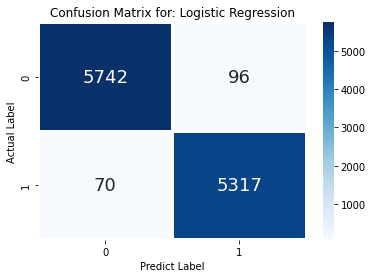

In [ ]:
# Visualize the Confusion Matrix for LogisticRegression!
plot_confusion_matrix(y_test, prediction, "Logistic Regression", plt.cm.Blues)

In [ ]:
pickle.dump(LR_Model, open('/content/drive/MyDrive/Dataset/LR', 'wb'))

LSTM

In [ ]:
# Obtain the total words present in the dataset
vocab = []
for i in data.tokenization:
    for j in i:
      vocab.append(j)
len(vocab)

9277072

In [ ]:
# Obtain the total number of unique words
unique_list = len(list(set(vocab)))
print(unique_list)

108705


Creating embedding

In [ ]:
# length of maximum document will be needed to create word embeddings 
max_length = -1
docs = data.tokenization_merged
for doc in docs:
    tokens = nltk.word_tokenize(doc)
    length = len(tokens)
    if(max_length<length):
        max_length = length
print(max_length)

4406


In [ ]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = unique_list)
tokenizer.fit_on_texts(x_train)
trainSequence = tokenizer.texts_to_sequences(x_train)
testSequence = tokenizer.texts_to_sequences(x_test)

Padding

In [ ]:
trainPadding = pad_sequences(trainSequence,maxlen = 60, padding = 'post', truncating = 'post')
testPadding = pad_sequences(testSequence,maxlen = 60, truncating = 'post') 

In [ ]:
firstInput = Input(shape=(60, ), dtype='int32')
a = Embedding(unique_list, 256) # Embedding word dimension 
embeddingStep= a 
b = embeddingStep(firstInput)
firstEmbedding = b
c = LSTM(256) # LSTM output vector dimension 
lstm_common = c 
firstOutput = lstm_common(firstEmbedding)

In [ ]:
# Since it is a binary classification we will use sigmoid as a dense layer for activation.
layer =  Dense(units=1, activation='sigmoid')
prediction = layer(firstOutput)
LSTM_Model = Model(inputs=firstInput, outputs=prediction)

In [ ]:
# It defines the loss function, optimizer and metrics
LSTM_Model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
Y_train_array = np.asarray(y_train)
Y_test_array = np.asarray(y_test)
# Model training 
LSTM_Model.fit(x=trainPadding, y=Y_train_array,batch_size = 256,epochs = 10,validation_data=(testPadding, Y_test_array),shuffle=True)

Epoch 1/10
132/132 [==============================] - 211s 2s/step - loss: 0.1107 - accuracy: 0.9620 - val_loss: 0.3244 - val_accuracy: 0.9559
Epoch 2/10
132/132 [==============================] - 204s 2s/step - loss: 0.0168 - accuracy: 0.9964 - val_loss: 0.3705 - val_accuracy: 0.9409
Epoch 3/10
132/132 [==============================] - 204s 2s/step - loss: 0.0059 - accuracy: 0.9994 - val_loss: 0.5419 - val_accuracy: 0.9419
Epoch 4/10
132/132 [==============================] - 204s 2s/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.2647 - val_accuracy: 0.9442
Epoch 5/10
132/132 [==============================] - 206s 2s/step - loss: 0.0167 - accuracy: 0.9971 - val_loss: 0.2437 - val_accuracy: 0.9512
Epoch 6/10
132/132 [==============================] - 206s 2s/step - loss: 0.0304 - accuracy: 0.9946 - val_loss: 0.0864 - val_accuracy: 0.9817
Epoch 7/10
132/132 [==============================] - 205s 2s/step - loss: 0.0087 - accuracy: 0.9984 - val_loss: 0.4387 - val_accuracy: 0.9275

In [ ]:
prediction = LSTM_Model.predict(testPadding)

In [ ]:
#Classification of real and fake with predicted values.
#If the predicted value is > 0.5, then it is real news otherwise fake news.
predicted = []
length = len(prediction)
for i in range(length):
    if prediction[i].item() > 0.5:
        predicted.append(1)
    else:
        predicted.append(0)

In [ ]:
report(y_test, predicted, "LSTM")

Report: LSTM

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5838
           1       0.99      0.87      0.93      5387

    accuracy                           0.93     11225
   macro avg       0.94      0.93      0.93     11225
weighted avg       0.94      0.93      0.93     11225



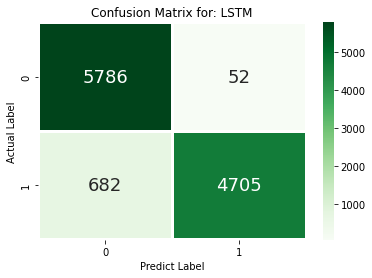

In [ ]:
# Visualize the Confusion Matrix for LSTM!
plot_confusion_matrix(y_test, predicted, "LSTM", plt.cm.Greens)

In [ ]:
pickle.dump(LSTM_Model, open('/content/drive/MyDrive/Dataset/LSTM', 'wb'))

INFO:tensorflow:Assets written to: ram://dab385d2-b590-430a-952f-588ba6cefbb3/assets


INFO:tensorflow:Assets written to: ram://dab385d2-b590-430a-952f-588ba6cefbb3/assets


# RFC_BestModel

In [ ]:
pipeline_RF = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer(norm='l2')),('model', RandomForestClassifier(n_jobs = -1, random_state = 42))])

In [ ]:
RFC_Model = pipeline_RF.fit(x_train, y_train)

In [ ]:
prediction = RFC_Model.predict(x_test)

In [ ]:
report(y_test, prediction, "Random Forest")

Report: Random Forest

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5912
           1       0.99      0.99      0.99      5313

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



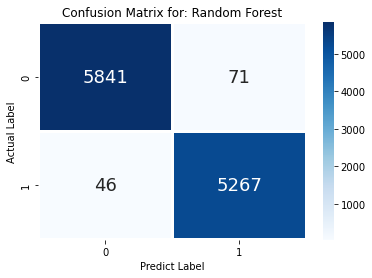

In [ ]:
# Visualize the Confusion Matrix for Random Forest!
plot_confusion_matrix(y_test, prediction, "Random Forest", plt.cm.Blues)

In [ ]:
pickle.dump(RFC_Model, open('/content/drive/MyDrive/Dataset/RFC', 'wb'))